In [719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tracking_data = pd.read_pickle('tracking_data.pkl')
tracking_data_full = pd.read_pickle('tracking_data_full.pkl')
tracking = pd.read_pickle('tracking.pkl')

In [720]:
import pandas as pd

ballbesitz = tracking[tracking['POSSESSION_TRACKABLE_OBJECT'].notna()]

spieler_team_df = ballbesitz[['POSSESSION_TRACKABLE_OBJECT', 'POSSESSION_GROUP']].drop_duplicates()

spieler_team_map = spieler_team_df.groupby('POSSESSION_TRACKABLE_OBJECT')['POSSESSION_GROUP'].agg(lambda x: x.mode())
away_team_ids = spieler_team_map[spieler_team_map == "away team"].index.tolist()
home_team_ids = spieler_team_map[spieler_team_map == "home team"].index.tolist()

In [721]:
tracking_ball = tracking_data_full[tracking_data_full['TRACK_ID'] == 55].copy()
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,00:00:00.1,0 days 00:00:00.100000
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,00:00:00.2,0 days 00:00:00.200000
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,00:00:00.3,0 days 00:00:00.300000
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,00:00:00.4,0 days 00:00:00.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,-31.62,-5.59,2.0,home team,<NA>,01:34:35.8,0 days 01:34:35.800000
1108559,105690,57449,55,55,False,-30.79,-4.73,2.0,home team,<NA>,01:34:35.9,0 days 01:34:35.900000
1108580,105690,57450,55,55,False,-29.94,-3.75,2.0,home team,<NA>,01:34:36,0 days 01:34:36
1108604,105690,57451,55,55,False,-29.56,-2.92,2.0,home team,<NA>,01:34:36.1,0 days 01:34:36.100000


Der Ball fliegt gerade wenn die Geschwindikeit hoch ist und die Richtung des Balls sich nicht stark ändert.

In [722]:
tracking_ball['ball_in_game'] = tracking_ball['TIME_DELTA'].diff() <= "00:00:00.1"

In [723]:
tracking_ball['dX'] = tracking_ball['X'].diff()
tracking_ball['dY'] = tracking_ball['Y'].diff()

In [724]:
tracking_ball['speed'] = np.sqrt(tracking_ball['dX']**2 + tracking_ball['dY']**2)

In [725]:
tracking_ball['angle'] = np.degrees(np.arctan2(tracking_ball['dY'], tracking_ball['dX']))
tracking_ball['angle_change'] = tracking_ball['angle'].diff()

tracking_ball['angle_shifted_2'] = tracking_ball['angle'].shift(-2)

tracking_ball['angle_diff_2frames'] = tracking_ball['angle_shifted_2'] - tracking_ball['angle']

In [726]:
tracking_ball['ball_in_motion'] = (tracking_ball['speed'] >= 0.5) & (tracking_ball['angle_change'] <=10) & (tracking_ball['ball_in_game']) & ( tracking_ball['angle_diff_2frames'] <=10)

Bei einem Pass muss der Ball mindestens 5 Frames hintereinander in Bewegung sein. Filtere also nur diejenigen Frames bei denen ball_in_motion jeweils 5mal hintereinander True ist

In [727]:
tracking_ball['motion_number'] = (tracking_ball['ball_in_motion'] != tracking_ball['ball_in_motion'].shift()).cumsum()

group_sizes = tracking_ball.groupby('motion_number')['ball_in_motion'].transform('sum')

tracking_ball['pass'] = (tracking_ball['ball_in_motion']) & (group_sizes >= 8)

In [728]:
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,dX,dY,speed,angle,angle_change,angle_shifted_2,angle_diff_2frames,ball_in_motion,motion_number,pass
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,-143.746162,NaN,False,1,False
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,...,-0.15,-0.61,0.628172,-103.815025,NaN,-161.816347,-58.001322,False,1,False
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,...,-1.35,-0.99,1.674097,-143.746162,-39.931137,-129.173658,14.572504,False,1,False
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,...,-1.37,-0.45,1.442012,-161.816347,-18.070185,-128.157227,33.659120,False,1,False
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,...,-0.22,-0.27,0.348281,-129.173658,32.642689,-122.660913,6.512745,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,-31.62,-5.59,2.0,home team,<NA>,...,0.68,0.75,1.012373,47.802452,2.802452,49.063366,1.260914,True,4206,False
1108559,105690,57449,55,55,False,-30.79,-4.73,2.0,home team,<NA>,...,0.83,0.86,1.195199,46.016978,-1.785473,65.400209,19.383231,False,4207,False
1108580,105690,57450,55,55,False,-29.94,-3.75,2.0,home team,<NA>,...,0.85,0.98,1.297266,49.063366,3.046388,38.027231,-11.036135,True,4208,False
1108604,105690,57451,55,55,False,-29.56,-2.92,2.0,home team,<NA>,...,0.38,0.83,0.912853,65.400209,16.336843,NaN,NaN,False,4209,False


In [729]:
passes = tracking_ball[tracking_ball['pass'] == True].copy()

Nummeriere Pässe durch

In [730]:
unique_motions = passes['motion_number'].dropna().unique()
motion_map = {old: new for new, old in enumerate(sorted(unique_motions), start=1)}

passes['motion_number'] = passes['motion_number'].map(motion_map)

In [731]:
passes

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,dX,dY,speed,angle,angle_change,angle_shifted_2,angle_diff_2frames,ball_in_motion,motion_number,pass
829,105690,96,55,55,True,-1.23,2.40,1.0,away team,28566,...,-0.64,0.56,0.850412,138.814075,8.387996,147.414293,8.600218,True,1,True
852,105690,97,55,55,True,-2.04,3.00,1.0,away team,<NA>,...,-0.81,0.60,1.008018,143.471145,4.657070,150.668160,7.197016,True,1,True
875,105690,98,55,55,True,-3.01,3.62,1.0,away team,<NA>,...,-0.97,0.62,1.151217,147.414293,3.943148,150.615843,3.201550,True,1,True
898,105690,99,55,55,True,-4.06,4.21,1.0,away team,<NA>,...,-1.05,0.59,1.204409,150.668160,3.253868,150.054317,-0.613844,True,1,True
921,105690,100,55,55,True,-5.09,4.79,1.0,away team,<NA>,...,-1.03,0.58,1.182074,150.615843,-0.052318,149.905759,-0.710084,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107321,105690,57395,55,55,False,-39.08,-12.27,2.0,away team,<NA>,...,-0.69,0.71,0.990051,134.181545,1.945402,132.552951,-1.628593,True,866,True
1107339,105690,57396,55,55,False,-39.70,-11.62,2.0,away team,<NA>,...,-0.62,0.65,0.898276,133.646808,-0.534736,132.108730,-1.538078,True,866,True
1107362,105690,57397,55,55,False,-40.26,-11.01,2.0,away team,<NA>,...,-0.56,0.61,0.828070,132.552951,-1.093857,129.143986,-3.408965,True,866,True
1107390,105690,57398,55,55,False,-40.73,-10.49,2.0,away team,<NA>,...,-0.47,0.52,0.700928,132.108730,-0.444221,127.746805,-4.361925,True,866,True


In [732]:
len(passes['motion_number'].unique())

866

In [733]:
passes_home_first_half = passes[(passes['PERIOD'] == 2.0) & (passes['POSSESSION_GROUP'] == 'home team')]

In [734]:
pass_numbers = passes_home_first_half['motion_number'].unique()

In [735]:
len(pass_numbers)

216

In [736]:
# Funktion zur Extraktion eines Passes als eine Zeile
def extract_pass_info(group):
    start = group.iloc[0]
    end = group.iloc[-1]
    
    return pd.Series({
        'motion_number': start['motion_number'],
        'start_X': start['X'],
        'start_Y': start['Y'],
        'end_X': end['X'],
        'end_Y': end['Y'],
        'PERIOD': start['PERIOD'],
        'POSSESSION_GROUP_start': start['POSSESSION_GROUP'],
        'POSSESSION_GROUP_end': end['POSSESSION_GROUP'],
        'FRAME_START': start['FRAME'],
        'FRAME_END': end['FRAME'],
        'POSSESSION_TRACKABLE_OBJECT': start['POSSESSION_TRACKABLE_OBJECT'],
        'Angekommen': start['POSSESSION_GROUP'] == end['POSSESSION_GROUP']
    })

# Nach motion_number gruppieren und pro Pass zusammenfassen
passes_summary = passes.groupby('motion_number').apply(extract_pass_info).reset_index(drop=True)

In [737]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen
0,1,-1.23,2.40,-13.96,11.76,1.0,away team,away team,96,114,28566,True
1,2,-13.84,12.75,-3.90,28.36,1.0,away team,away team,116,131,24372,True
2,3,0.32,31.75,-8.89,29.12,1.0,home team,home team,174,188,<NA>,True
3,4,-6.60,24.64,7.12,25.91,1.0,away team,away team,233,240,<NA>,True
4,5,8.95,31.28,17.63,24.20,1.0,away team,home team,259,267,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True
862,863,6.68,-20.79,-7.24,-28.90,2.0,away team,away team,57136,57153,<NA>,True
863,864,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True
864,865,-32.55,0.98,-20.84,-28.49,2.0,away team,away team,57355,57368,<NA>,True


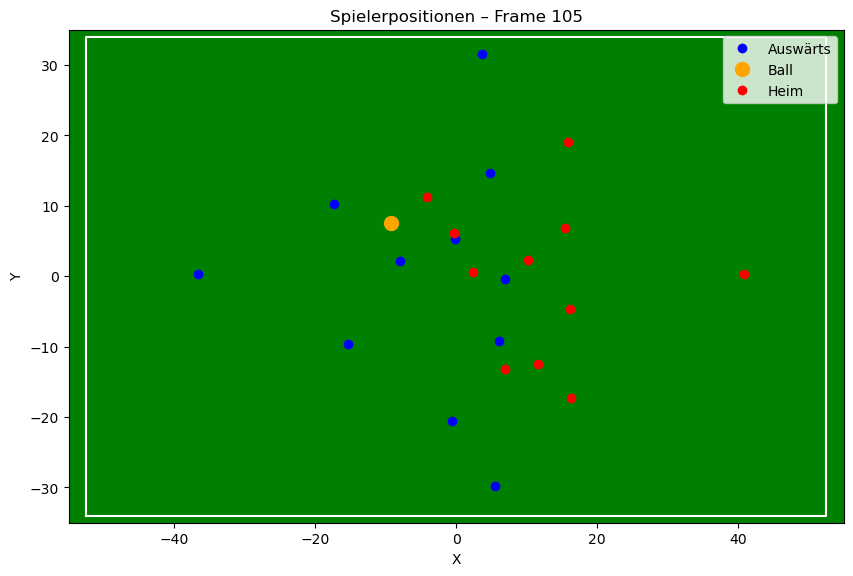

In [738]:
import matplotlib.pyplot as plt

def plot_spieler(tracking_df, frame, team0_ids=None, team1_ids=None, ball_id=55):
    df = tracking_df[tracking_df['FRAME'] == frame]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Spielfeld zeichnen (vereinfachtes Rechteck)
    ax.set_facecolor('green')
    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

    ax.set_xlim(-55, 55)
    ax.set_ylim(-35, 35)
    ax.set_aspect('equal')

    # Flags, um Label nur einmal hinzuzufügen
    ball_plotted = False
    team0_plotted = False
    team1_plotted = False

    for _, row in df.iterrows():
        if row['TRACK_ID'] == ball_id:
            if not ball_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball')
                ball_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10)
        elif team0_ids and row['TRACK_ID'] in team0_ids:
            if not team0_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts')
                team0_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='blue')
        elif team1_ids and row['TRACK_ID'] in team1_ids:
            if not team1_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim')
                team1_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='red')
        else:
            ax.plot(row['X'], row['Y'], 'o', color='gray')

    plt.title(f"Spielerpositionen – Frame {frame}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc='upper right')
    plt.show()


plot_spieler(tracking_data, 105, away_team_ids, home_team_ids)

Als Nächtes möchte ich den Passgeber und Passempfänger identifizieren. Leider hat die Spalte 'POSSESSION_TRACKABLE_OBJECT'. Daher nehme ich den nächsten Spieler zum Ball. Falls eine Ballbesitzmannschaft bekannt ist, nehme ich den nächsten Spieler zum Ball aus dieser Mannschaft.

In [739]:
def get_closest_player(frame, possession_group ,ball_id=55):

    #if POSSESSION_GROUP is known we search the clsoest player of this team

    frame_data = tracking_data[tracking_data['FRAME'] == frame]
    ball_pos = frame_data[frame_data['TRACK_ID'] == ball_id][['X', 'Y']]

    ball_x, ball_y = ball_pos.iloc[0]['X'], ball_pos.iloc[0]['Y']

    if possession_group == 'home team':
        players = frame_data[(frame_data['TRACK_ID'] != ball_id) & (frame_data['TRACK_ID'].isin(home_team_ids))][['TRACK_ID', 'X', 'Y']].copy()
    elif possession_group == "away team":
        players = frame_data[(frame_data['TRACK_ID'] != ball_id) & (frame_data['TRACK_ID'].isin(away_team_ids))][['TRACK_ID', 'X', 'Y']].copy()
    else:
        players = frame_data[(frame_data['TRACK_ID'] != ball_id)][['TRACK_ID', 'X', 'Y']].copy()


    players['distance_to_ball'] = ((players['X'] - ball_x)**2 + (players['Y'] - ball_y)**2)**0.5

    closest_player_id = players.loc[players['distance_to_ball'].idxmin()] ['TRACK_ID']

    return closest_player_id

get_closest_player(96, None)

28566.0

In [743]:
passes_summary['Passgeber'] = passes_summary.apply(
    lambda row: get_closest_player(row['FRAME_START'], row['POSSESSION_GROUP_start']),
    axis=1
)
passes_summary['Passempfänger'] = passes_summary.apply(
    lambda row: get_closest_player(row['FRAME_END'], row['POSSESSION_GROUP_end']),
    axis=1
)

Visualisiere Pässe von einem Spieler

In [744]:
motion_numbers = passes_summary[(passes_summary['POSSESSION_GROUP_end'] == 'away team') & (passes_summary['PERIOD'] == 1)]['motion_number']

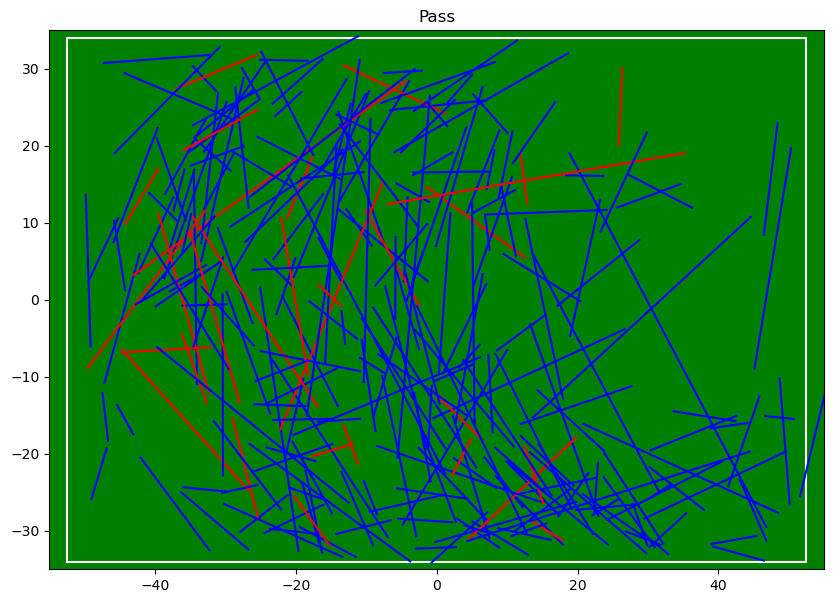

In [745]:
def visualize_passes(passes_summary, motion_numbers):
    pass_sequence = passes_summary[passes_summary['motion_number'].isin(motion_numbers)]
    
    plt.figure(figsize=(10, 7))
    plt.title("Pass")

    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
    plt.gca().set_facecolor("green")
    plt.xlim(-55, 55)
    plt.ylim(-35, 35)

    for _, row in pass_sequence.iterrows():
        color = 'blue' if row['Angekommen'] else 'red'
        plt.plot([row['start_X'], row['end_X']], [row['start_Y'], row['end_Y']],  color)

    plt.show()

visualize_passes(passes_summary, motion_numbers)


In [746]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger
0,1,-1.23,2.40,-13.96,11.76,1.0,away team,away team,96,114,28566,True,28566.0,24372.0
1,2,-13.84,12.75,-3.90,28.36,1.0,away team,away team,116,131,24372,True,24372.0,39023.0
2,3,0.32,31.75,-8.89,29.12,1.0,home team,home team,174,188,<NA>,True,16427.0,16471.0
3,4,-6.60,24.64,7.12,25.91,1.0,away team,away team,233,240,<NA>,True,24372.0,28566.0
4,5,8.95,31.28,17.63,24.20,1.0,away team,home team,259,267,<NA>,False,39023.0,39015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0
862,863,6.68,-20.79,-7.24,-28.90,2.0,away team,away team,57136,57153,<NA>,True,39023.0,39023.0
863,864,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True,14926.0,29957.0
864,865,-32.55,0.98,-20.84,-28.49,2.0,away team,away team,57355,57368,<NA>,True,29957.0,39023.0


In [753]:
def überspielte_verteidiger(start_frame, end_frame, possession_group, period):

    start_data = tracking_data[tracking_data['FRAME'] == start_frame]
    end_data = tracking_data[tracking_data['FRAME'] == end_frame]
    
    ball_start = start_data[start_data['TRACK_ID'] == 55][['X', 'Y']].iloc[0]
    ball_end = end_data[end_data['TRACK_ID'] == 55][['X', 'Y']].iloc[0]

    if possession_group == 'home team':
        gegner_ids = away_team_ids
    elif possession_group == 'away team':
        gegner_ids = home_team_ids
    else:
        return np.nan

    gegner_start = start_data[start_data['TRACK_ID'].isin(gegner_ids)][['TRACK_ID', 'X', 'Y']].copy()
    gegner_end = end_data[end_data['TRACK_ID'].isin(gegner_ids)][['TRACK_ID', 'X', 'Y']].copy()


    def zwischen_ball_und_tor(pos, team):
        if (team == 'away team' and period == 1) or (team == 'home team' and period == 2):
            return pos['X'] > ball_start['X']  # Richtung rechtes Tor
        else:
            return pos['X'] < ball_start['X']  # Richtung linkes Tor

    gegner_start['zwischen'] = gegner_start.apply(lambda row: zwischen_ball_und_tor(row, possession_group), axis=1)
    gegner_end['zwischen'] = gegner_end.apply(lambda row: zwischen_ball_und_tor(row, possession_group), axis=1)

    überspielt = gegner_start[(gegner_start['zwischen']) & 
                              (~gegner_start['TRACK_ID'].isin(gegner_end[gegner_end['zwischen']]['TRACK_ID']))]

    return len(überspielt)


In [754]:
passes_summary['überspielte Verteidiger'] = passes_summary.apply(
    lambda row: überspielte_verteidiger(row['FRAME_START'], row['FRAME_END'], row['POSSESSION_GROUP_start'], row['PERIOD']),
    axis=1
)

In [758]:
np.max(passes_summary['überspielte Verteidiger'])

6.0